In [1]:
import sys
sys.path.append("../code/")

from importlib import reload  
import lib_LinearAlgebra
import util_ElasticNet
import lib_ElasticNet
import lib_Checker
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_ElasticNet = reload(util_ElasticNet)
lib_ElasticNet = reload(lib_ElasticNet)
lib_Checker = reload(lib_Checker)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py

# Simulate data

In [2]:
n = 1000
k = 2000
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome]) / 10
beta[5:, :] = 0
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([0, 0, 0, 0])  # [230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

In [3]:
# with h5py.File('debug_en_tmp.hdf5', 'w') as f:
#     f.create_dataset('x', data = x)
#     f.create_dataset('y', data = y)
#     f.create_dataset('covar', data = covar)
#     f.create_dataset('beta', data = beta)
#     f.create_dataset('bcovar', data = bcovar)

In [4]:
# with h5py.File('debug_en_tmp.hdf5', 'r') as f:
#     x = f['x'][:]
#     y = f['y'][:]
#     covar = f['covar'][:]
#     beta = f['beta'][:]
#     bcovar = f['bcovar'][:]

In [5]:
# beta

Pack it as a dataset.

In [6]:
train_prop = 0.8
ntrain = int(n * train_prop)
train_batch = 512 # ntrain

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset_train = dataset.take(ntrain)
dataset = dataset.skip(ntrain)
dataset_train = dataset_train.batch(train_batch).repeat(200)
dataset_valid = dataset

In [8]:
x

array([[-0.80456092,  0.22406942,  0.52180391, ...,  0.88219939,
        -0.03714367, -0.32456744],
       [ 0.31108437,  0.2260774 ,  0.97691245, ...,  0.19365635,
         0.7365623 , -0.25451263],
       [-1.24221893, -0.98757883, -0.59030683, ..., -0.86888124,
        -1.4633885 , -2.24193551],
       ...,
       [ 1.27831634,  1.9982817 , -0.42984286, ...,  0.71739418,
        -0.59199956,  0.49633093],
       [-2.2481309 , -0.10822419, -2.41436902, ..., -0.948918  ,
         1.05656043,  1.50004663],
       [ 1.06808911, -1.30139985, -0.10843245, ...,  0.36099689,
         1.70636105,  0.24408656]])

Create the data scheme for loading x, y, and covariates.

In [9]:
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset_train, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0], 
    covariate_indice = [4, 5]
)

In [10]:
data_scheme.num_predictors

2000

Load validation data into memory.

In [11]:
for ele in dataset_valid.batch(10000):
    xvalid, yvalid = data_scheme.get_data_matrix(ele)
    yvalid = yvalid[:, 0][:, np.newaxis]
    break

# Run elastic net in crappy way

In [12]:
# Moved to lib_Checker.py
# import functools
# def my_stat_fun(np_1dim_array):
#     return np.mean(np_1dim_array)
# def diff_stop_rule(summary, threshold):
#     n = len(summary)
#     if n >= 2:
#         return (summary[n - 2] - summary[n - 1]) / max(abs(summary[n - 2]), abs(summary[n - 1])) < threshold
#     else:
#         return False
# my_stop_rule = functools.partial(diff_stop_rule, threshold = 1e-4)
# class Checker:
#     def __init__(self, sample_size, batch_size, stat_fun, stop_rule):
#         self.sample_size = sample_size
#         self.batch_size = batch_size
#         self.nbatch = self._get_nbatch()
#         self.iter_counter = 0
#         self.epoch_counter = 0
#         self.criteria_raw = []
#         self.criteria_summary = []
#         self.stat_fun = stat_fun
#         self.stop_rule = stop_rule
#         # internal state for current epoch
#         self._criteria_curr = self._empty_criteria_curr()  
#         self._iter_in_epoch_counter = 0
#     def update(self, step_size = 1):
#         '''
#         update the internal states and return -1 if still in the same epoch or 0 if update epoch
#         '''
#         self.iter_counter += step_size
#         epoch_now = self._get_curr_epoch()
#         if epoch_now == self.epoch_counter:
#             self._iter_in_epoch_counter += 1
#             return -1
#         elif epoch_now == self.epoch_counter + 1:
#             self._iter_in_epoch_counter = 0
#             self.epoch_counter += 1
#             return 0
#     def record(self, update_return, criteria):
#         '''
#         it should only be run after running update
#         '''
#         self.criteria_raw.append([self.iter_counter, self.epoch_counter, criteria])
#         self._criteria_curr[self._iter_in_epoch_counter] = criteria
#         if update_return == -1:
#             pass
#         elif update_return == 0:
#             self.criteria_summary.append(self.stat_fun(self._criteria_curr))
#             self._criteria_curr = self._empty_criteria_curr()
#             return 0
#     def ifstop(self):
#         return self.stop_rule(self.criteria_summary)
#     def _empty_criteria_curr(self):
#         return np.empty((self.nbatch, ))
#     def _get_nbatch(self):
#         div = int(self.sample_size / self.batch_size) 
#         if self.sample_size % self.batch_size == 0:
#             return div
#         else:
#             return div + 1
#     def _get_curr_epoch(self):
#         return int(self.iter_counter / self.sample_size)

In [13]:
import functools
my_stop_rule = functools.partial(lib_Checker.diff_stop_rule, threshold = 1e-4)

In [14]:
ntrain

800

In [15]:
alpha = 0.5
learning_rate = 0.05
nx = data_scheme.get_num_covariate() + data_scheme.get_num_predictor()
# model
model_lseq = lib_ElasticNet.ElasticNet(nx, alpha, 0)
# lambda seq
lambda_max = util_ElasticNet.get_lambda_max(model_lseq, xvalid, yvalid) * 2
lambda_seq = util_ElasticNet.get_lambda_sequence(lambda_max, lambda_max / 1e3, 100)
# update rule
updater = lib_ElasticNet.ProximalUpdater(learning_rate)
n = 0
betahat = np.empty((beta.shape[0], len(lambda_seq)))
path = []
counter = 0
for lambda_i in lambda_seq:
    print('lambda = {}'.format(lambda_i))
    model_lseq.update_lambda(lambda_i)
    i = 0
    checker = lib_Checker.Checker(ntrain, train_batch, lib_Checker.my_stat_fun, my_stop_rule)
    for ele in data_scheme.dataset:
        x, y = data_scheme.get_data_matrix(ele)
        step_size = x.shape[0]
        if i % 100 == 0:
            print('i = {}, model1 = {}'.format(i, model_lseq.objective(x, y)[0]))
        i += 1
        n += 1
        obj, loss = updater.proximal_train_step(model_lseq, x, y)
        update_status = checker.update(step_size)
        if update_status == 0:
            vloss = model_lseq.objective(x, y)[0]
            checker.record(update_status, vloss)
            if checker.ifstop() == True:
                break
#             print('checker ifstop = {}'.format(checker.ifstop()))
    betahat[:, counter] = model_lseq.A[:beta.shape[0], 0]
    path.append(np.array(checker.criteria_summary))
    counter += 1

lambda = 11.117871278748975
i = 0, model1 = 9.145807266235352
lambda = 10.368563979701756
i = 0, model1 = 8.300065994262695
lambda = 9.66975748376049
i = 0, model1 = 8.301004409790039
lambda = 9.018048205883916
i = 0, model1 = 8.301630020141602
lambda = 8.410261951266579
i = 0, model1 = 8.302043914794922
lambda = 7.843438455204996
i = 0, model1 = 8.30231761932373
lambda = 7.314816964925065
i = 0, model1 = 8.302497863769531
lambda = 6.821822793146029
i = 0, model1 = 8.302616119384766
lambda = 6.362054777889229
i = 0, model1 = 8.302694320678711
lambda = 5.93327358745373
i = 0, model1 = 8.300554275512695
lambda = 5.533390813597454
i = 0, model1 = 8.2916841506958
lambda = 5.160458799801378
i = 0, model1 = 8.269867897033691
lambda = 4.812661155074669
i = 0, model1 = 8.234212875366211
lambda = 4.488303907097586
i = 0, model1 = 8.188545227050781
lambda = 4.185807251612939
i = 0, model1 = 8.133933067321777
lambda = 3.903697857880934
i = 0, model1 = 8.07052230834961
lambda = 3.640601692720591
i

In [16]:
tmp = path[0]
for i in range(1, len(path)):
    tmp = np.concatenate((tmp, path[i]), axis = 0)
# path = np.reshape(tmp, newshape = tmp.shape[0] * tmp.shape[1])

In [17]:
path[0].shape

(23,)

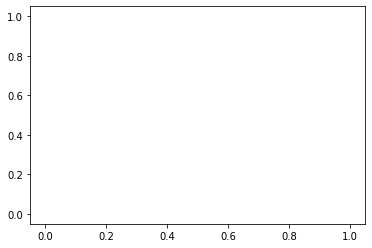

In [18]:
plt.plot(tmp[400:])

In [19]:
betahat[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

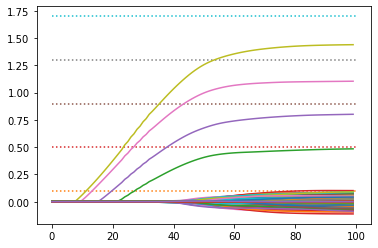

In [20]:
fig, aes = plt.subplots()
for i in range(betahat.shape[0]):
    aes.plot(betahat[i, :])
    if beta[i, 0] != 0:
        aes.plot([0, 100], [beta[i, 0], beta[i, 0]], ':')
# plt.plot(betahat[0,:])
# plt.plot(betahat[10,:])
# plt.plot(betahat[9,:])
# plt.plot(betahat[2,:])
# plt.plot(betahat[1,:])
# plt.plot(betahat[4,:])
# plt.plot(betahat[3,:])

In [25]:
path

[array([4.21940279, 4.05820084, 3.94856644, 3.87350082, 3.82171202,
        3.78567672, 3.76036787, 3.74241376, 3.7295413 , 3.72021055,
        3.71337128, 3.70830369, 3.70450759, 3.70163679, 3.69944382,
        3.69775558, 3.69644499, 3.69542193, 3.69461703, 3.69398165,
        3.69347763, 3.6930759 , 3.69275546]),
 array([3.69249892, 3.69229293]),
 array([3.69212723, 3.69199419]),
 array([3.69188643, 3.69180012]),
 array([3.69173002, 3.69167376]),
 array([3.69162798, 3.6915915 ]),
 array([3.69156146, 3.69153762]),
 array([3.69151807, 3.69150209]),
 array([3.69099522, 3.69090009]),
 array([3.68785095, 3.68755913]),
 array([3.68212271, 3.68201876]),
 array([3.67239547, 3.67236328]),
 array([3.65812492, 3.65808415]),
 array([3.63945317, 3.63939834]),
 array([3.61672878, 3.61668205]),
 array([3.59035945, 3.59059215]),
 array([3.55926919, 3.55956411]),
 array([3.52233386, 3.52256083]),
 array([3.47974205, 3.47990751]),
 array([3.43195772, 3.43206406]),
 array([3.37945795, 3.37950516]),
 a